# Code from adsz's notebook

In [1]:
from math import pi
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.visualization import plot_histogram
from typing import Dict

In [2]:
COSTS: Dict[str, int] = {
    'cx': 10, 'u': 1, 'p': 1,
    'u1': 1, 'u2': 1, 'u3': 1, 
    't': 1, 'tdg': 1,
    'x': 1, 'z': 1, 'h': 1,
    'ry': 1, 
    'measure': 0,
}

def compute_cost(qc: QuantumCircuit) -> int:
    qcu = PassManager(Unroller(['cx', 'u3', 'u1', 't', 'tdg', 'u', 'p'])).run(qc)
    return sum(COSTS[op]*count for op, count in qcu.count_ops().items()) 

In [3]:
problem_set = [
    [['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
    [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
    [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
    [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
    [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']],
    [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
    [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
    [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
    [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']],
]

In [4]:
def read_board(spec):
    """ Just read the data into np.array with values 1: asteroid, 0: no asteroid """
    board = np.zeros((4,4), dtype=int)
    for r, c in spec:
        board[int(r), int(c)] = 1
    return board
    
def simulate(qc, title='Histogram'):
    job = execute(qc, QasmSimulator(precision='single'), shots=1000, seed_simulator=12345)

    result = job.result()
    counts_by_board = {
        int(measured[::-1].split(' ')[0], 2): count
        for measured, count in result.get_counts().items()
    }
    
    return plot_histogram(counts_by_board, bar_labels=False, title=f'{title} (cost {compute_cost(qc)})')

In [5]:
def mrg(qc, q0, q1, q2, mask=(True, True),
        left_open=False, right_open=False, right_cut=False):
    
    if not left_open:
        qc.ry(pi/4, q2)
    qc.cx(q1, q2)
    
    if mask[1]:
        qc.ry(pi/4, q2)
    else:
        # qc.x(q2)        
        # qc.ry(pi/4, q2)
        qc.u3(3/4*pi, pi, 0, q2)
    
    qc.cx(q0, q2)
    
    if not right_cut:
    
        if mask == (True, True):
            qc.ry(-pi/4, q2)
        elif mask == (True, False):        
            # qc.ry(-pi/4, q2)
            # qc.x(q2)
            qc.u3(3/4*pi, -pi, 0, q2)
        elif mask == (False, True):
            # qc.x(q2)    
            # qc.ry(-pi/4, q2)
            qc.u3(3/4*pi, 0, pi, q2)
        elif mask == (False, False):
            # qc.x(q2)    
            # qc.ry(-pi/4, q2)
            # qc.x(q2)
            qc.u3(1/4*pi, 0, 0, q2)

        qc.cx(q1, q2)

        if not right_open:
            qc.ry(-pi/4, q2)   

After a nearly two-week-long wait, we finally got to see the
[winning solution](https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/submissions/writeup_Nagayoshi.ipynb) of the Fall 2020 IBM Quantum Challenge. 
Below, we present our initial thoughts on what we were able to observe.

First, let us recall the following fragment of the contest rules.

"*When mapping the board information into your quantum circuit, you must not change the board information from the original one.*"

The winning solution does not map the full board information into the quantum circuit. Instead, it only classically checks whether 24 specific patterns of 
stars occur on each of the boards. It is worth noting the following two facts about such an approach:

*   It is lossy i.e. it is impossible to recover the board information from the data mapped into the quantum circuit.
*   It constitutes a significant classical step towards solving the problem. The only remaining work to be done by the circuit is to check for each board whether any of the 24 positions is marked, with the knowledge that this occurs for only one board (and no more than two positions are marked).

It is completely up to the organizers what consitutes "changing the board 
information from the original one". However, looking at the contests's Slack 
channel, it seems that most of the competitors think that such a change is going too far.

Let us leave the discussion if such an approach violates the rules or not, and instead let us see how small the solution circuit can be made using the same classical preprocessing. After all, that is what the contest was all about!

We applied the optimizations from our solutions (see [Adam's](blog/adsz-iqc-writeup.html) and [Witek's](blog/witek-iqc-writeup.html) write-ups), while preserving the amount of data
transmitted. The cost of the resulting circuit is 213. Enjoy reading the code!


## New concept of the buffer

Recall that the unsolvable board has at most one odd and at most one even permutation marked.
Therefore, instead of storing the full bitmap of 24 permutations, it is enough to store two indices – one for the (potential) odd permutation and one for the (potential) even permutation.
We use a data buffer in the following way:
`qbuf[0:4]` stores the id of the even permutation and `qbuf[4:8]` – the odd one.
Zero is treated as no permutation appearing.

To indicate the id of the buffer associated with a particular board we assign the buffer slot in `qbufid` variable (0 – none, 1 – the first buffer).
Observe that one bit is sufficient as we are guaranteed that only one of the boards is unsolvable i.e. no more than one buffer will be allocated.


In [6]:
def obtain4_many_cp(qc, inv, boards, qbid, qbidanc, qbuf, qbufid):
    qctrl = qbidanc[2]
    
    # We are guaranteed that only one board is unsolvable,
    # so we will heep the `qctrl` bit marked by performing explicit
    # open when first encountered and close after unloading the data.
    def open_ctrl(bid):
        mrg(qc, qbid[0], qbid[1], qbidanc[0],
            mask=(not (bid & 0b0001), not (bid & 0b0010)))
        mrg(qc, qbid[2], qbid[3], qbidanc[1],
            mask=(not (bid & 0b0100), not (bid & 0b1000)))
        mrg(qc, qbidanc[0], qbidanc[1], qbidanc[2])
        
    def close_ctrl(bid):
        mrg(qc, qbidanc[0], qbidanc[1], qbidanc[2])
        mrg(qc, qbid[2], qbid[3], qbidanc[1],
            mask=(not (bid & 0b0100), not (bid & 0b1000)))
        # Not uncomputing the following in small diffuser setting
        # mrg(qc, qbid[0], qbid[1], qbidanc[0],
        #   mask=(not (bid & 0b0001), not (bid & 0b0010)))
        
    opened_bid = None
    
    for bid in range(len(boards)):        
        for perm_id, p in enumerate(permutations_even()):
            for even in [True, False]:
                if all(boards[bid][i, p[i]] for i in range(4)):
                    if opened_bid is None:
                        if not inv:
                            open_ctrl(bid)
                        opened_bid = bid
                    else:
                        assert bid == opened_bid
                    
                    # Marking that the data associated
                    # with this board is in 1st buffer.
                    qc.cx(qctrl, qbufid)
                      
                    # The permutation id stored in the buffer
                    # (for even/odd permutations)
                    qsubbuf = [qbuf[0:4], qbuf[4:8]][even]
                    if (perm_id+1) & 0b0001:
                        qc.x(qsubbuf[3])
                    if (perm_id+1) & 0b0010:
                        qc.x(qsubbuf[2])
                    if (perm_id+1) & 0b0100:
                        qc.x(qsubbuf[1])
                    if (perm_id+1) & 0b1000:
                        qc.x(qsubbuf[0])                    
                    
                # Transform even permutation into odd one
                p = tuple([1, 0, 2, 3][p[i]] for i in range(4))
                    
    if opened_bid is not None:
        if inv:
            close_ctrl(opened_bid)

In [7]:
def permutations_even():
    return [
        (0, 1, 2, 3),
        (0, 2, 3, 1),
        (0, 3, 1, 2),
        (1, 0, 3, 2),
        (1, 2, 0, 3),
        (1, 3, 2, 0),
        (2, 0, 1, 3), 
        (2, 1, 3, 0),
        (2, 3, 0, 1),
        (3, 0, 2, 1),
        (3, 1, 0, 2),
        (3, 2, 1, 0),
    ]

In [8]:
def oracle_cp(qc, boards, qbid, qbuf, qbufid, qbidanc, qanc):  
    obtain4_many_cp(qc, False, boards, qbid, qbidanc, qbuf, qbufid)        
    mark_unsolvable_cp(qc, qbuf, qbufid, qanc)
    obtain4_many_cp(qc, True, boards, qbid, qbidanc, qbuf, qbufid)

Observe that `qbufid` has only one bit, therefore `qbufid[0] != 0` is equivalent to `qbufid == 1`, which implies that there is some permutation stored in the buffer associated with this board.

In [9]:
def mark_unsolvable_cp(qc, qbuf, qbufid, qanc):
    qc.z(qbufid[0])

In [10]:
def diffusion2(qc, qbits):
    assert len(qbits) == 2
    
    hx(qc, qbits[0])
    qc.z(qbits[1]) #HXH
    qc.cx(qbits[0], qbits[1])
    qc.z(qbits[1]) #HXH
    xh(qc, qbits[0])

In [11]:
def hx(qc, q):
    qc.u3(pi/2, 0, 0, q) 
    
def xh(qc, q):
    qc.u3(-pi/2, 0, 0, q)

In [12]:
def solution_cp(problem_set):
    boards = [read_board(board_spec) for board_spec in problem_set]
    
    # Board id [0 - MSB, 3 - LSB]      
    qbid = QuantumRegister(4, name='bid')
    
    # Buffer for the lossely compressed board info
    qbuf = QuantumRegister(8, name='buf') 
    
    qbufid = QuantumRegister(1, name='bufid') 
    
    qbidanc = QuantumRegister(3, name='bidanc')
    
    # General-purpose ancillae
    qanc = QuantumRegister(3, name='anc')
    
    # Measured answer (endianness as in `qbid`)
    cans = ClassicalRegister(4, name='c')

    qc = QuantumCircuit(
        qbid, qbuf, qbufid,
        qbidanc, qanc,
        cans,
    )                
        
    # Initial superposition
    qc.h(qbid)
    
    oracle_cp(qc, boards, qbid, qbuf, qbufid, qbidanc, qanc)
    
    diffusion2(qc, [qbid[2], qbid[3]])

    qc.measure(qbid, cans)
        
    return qc

<ipython-input-5-4b9af2a8039b>:13: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(3/4*pi, pi, 0, q2)


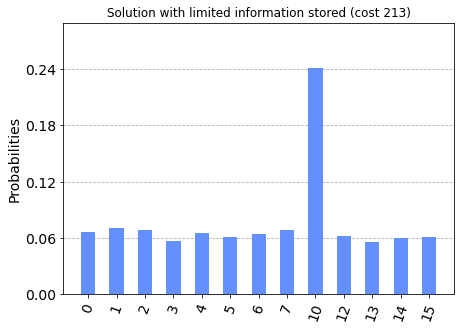

In [13]:
simulate(
    solution_cp(problem_set),
    title='Solution with limited information stored')